## Import Necessary Libs

In [1]:
import pandas as pd
import numpy as np
import random
from surprise import Dataset, Reader
from surprise import KNNBasic, KNNBaseline
from sklearn.metrics import average_precision_score, ndcg_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
ratings_df = pd.read_csv('ratings.dat', sep='::', engine='python', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df = ratings_df.drop(columns=['timestamp'])

In [3]:
# To avoid division by zero in the equations used later
EPSILON = 1e-9

# Task 1: User-based Collaborative Filtering


In [4]:
# Randomly select a user to reserve for testing
unique_users = ratings_df['user_id'].unique()
target_user = random.choice(unique_users)
print(f'Target User ID: {target_user}\n')

# Get the list of movies that the target user has rated
target_user_rated_movies = ratings_df[(ratings_df['user_id'] == target_user)][['movie_id', 'rating']].values

recommendations = []
actual_ratings = []

# Define the Reader object for Surprise
reader = Reader(rating_scale=(1, 5))  

# Load the data into Surprise's Dataset object
load_data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Make Train data set
train_data = load_data.build_full_trainset()

# Similarity measure configuration
sim_options = {'name': 'cosine', 'user_based': True}

# Define a list of k values to test
k_values = [2, 5, 10, 20, 50]

for k in k_values:
    # Create a user-based collaborative filtering model with the current k
    model = KNNBasic(k=k, sim_options=sim_options, verbose=False)

    # Fit the model on the training data
    model.fit(train_data)

    # Generate recommendations for the rated movies of the target user
    for movie_id, actual_rating in target_user_rated_movies:
        estimated_rating = model.predict(target_user, movie_id).est
        recommendations.append(estimated_rating)
        actual_ratings.append(actual_rating)

    # Calculate RMSE for this user and the current k
    rmse = np.sqrt((sum([(actual - estimated) ** 2 for actual, estimated in zip(actual_ratings, recommendations)])) / (len(recommendations) + EPSILON))
 
    # Print the k and RMSE
    print(f'Number of Neighbors (k): {k}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('\n')

Target User ID: 3178

Number of Neighbors (k): 2
Root Mean Squared Error (RMSE): 0.6359


Number of Neighbors (k): 5
Root Mean Squared Error (RMSE): 0.7938


Number of Neighbors (k): 10
Root Mean Squared Error (RMSE): 0.8846


Number of Neighbors (k): 20
Root Mean Squared Error (RMSE): 0.9552


Number of Neighbors (k): 50
Root Mean Squared Error (RMSE): 1.0155




# Task 2: Item-based Filtering

## Mean Squared Difference Similarity

In [5]:
# Randomly select a user to reserve for testing
unique_movies = ratings_df['movie_id'].unique()
target_movie = random.choice(unique_movies)

# Get the list of users who have rated the chosen item
users_rated_target_movie = ratings_df[ratings_df['movie_id'] == target_movie]['user_id'].unique()

recommendations = []
actual_ratings = []

# Define the Reader object for Surprise
reader = Reader(rating_scale=(1, 5))  

# Load the data into Surprise's Dataset object
load_data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Make Train data set
train_data = load_data.build_full_trainset()

In [6]:
# Similarity measure configuration
sim_options = {'name': 'msd', 'user_based': False}

# Create an item-based collaborative filtering model 
model = KNNBasic(k=5, sim_options=sim_options, verbose=False)

# Fit the model on the training data
model.fit(train_data)

# Generate recommendations for the users who rated the chosen item
for user_id in users_rated_target_movie:
    estimated_rating = model.predict(user_id, target_movie).est
    recommendations.append(estimated_rating)
    actual_rating = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['movie_id'] == target_movie)]['rating'].values[0]
    actual_ratings.append(actual_rating)

# Calculate RMSE for the users who rated the chosen item
rmse_msd = np.sqrt((sum([(actual - estimated) ** 2 for actual, estimated in zip(actual_ratings, recommendations)])) / (len(recommendations) + EPSILON))


## Pearson Similarity

In [7]:
# Similarity measure configuration
sim_options = {'name': 'pearson', 'user_based': False}

# Create an item-based collaborative filtering model 
model = KNNBasic(k=5, sim_options=sim_options, verbose=False)

# Fit the model on the training data
model.fit(train_data)

# Generate recommendations for the users who rated the chosen item
for user_id in users_rated_target_movie:
    estimated_rating = model.predict(user_id, target_movie).est
    recommendations.append(estimated_rating)
    actual_rating = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['movie_id'] == target_movie)]['rating'].values[0]
    actual_ratings.append(actual_rating)

# Calculate RMSE for the users who rated the chosen item
rmse_pearson = np.sqrt((sum([(actual - estimated) ** 2 for actual, estimated in zip(actual_ratings, recommendations)])) / (len(recommendations) + EPSILON))


In [8]:
print(f'RMSE for MSD similarity: {rmse_msd:.4f}')
print(f'RMSE for Pearson similarity: {rmse_pearson:.4f}')

RMSE for MSD similarity: 0.4336
RMSE for Pearson similarity: 0.5485


# Task 3: A Better Recommender System

### Task 3.1 - Option1RecSys

In [9]:
# Randomly select a user to reserve for testing
unique_users = ratings_df['user_id'].unique()
target_user = random.choice(unique_users)
print(f'Target User ID: {target_user}\n')

# Get the list of movies that the target user has rated
target_user_rated_movies = ratings_df[(ratings_df['user_id'] == target_user)][['movie_id', 'rating']].values

recommendations = []
actual_ratings = []

# Define the Reader object for Surprise
reader = Reader(rating_scale=(1, 5))  

# Load the data into Surprise's Dataset object
load_data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Make Train data set
train_data = load_data.build_full_trainset()

# Define a list of k values to test
k_values = [2, 5, 10, 20, 50]

for k in k_values:
    # Create a user-based collaborative filtering model with the current k
    model = KNNBaseline(
    k=k,
    bsl_options={
        'method': 'sgd',
        'n_epochs': 5,
        'learning_rate': 0.00005,
    },
    sim_options={
        'name': 'pearson_baseline',
        'user_based': False,
    },
    verbose=False
)

    # Fit the model on the training data
    model.fit(train_data)

    # Generate recommendations for the rated movies of the target user
    for movie_id, actual_rating in target_user_rated_movies:
        estimated_rating = model.predict(target_user, movie_id).est
        recommendations.append(estimated_rating)
        actual_ratings.append(actual_rating)

    # Calculate RMSE for this user and the current k
    rmse = (sum([(actual - estimated) ** 2 for actual, estimated in zip(actual_ratings, recommendations)])) / (len(recommendations) + EPSILON)
    rmse = np.sqrt(rmse)
 
    # Print the k and RMSE
    print(f'Number of Neighbors (k): {k}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print('\n')

Target User ID: 1424

Number of Neighbors (k): 2
Root Mean Squared Error (RMSE): 0.2154


Number of Neighbors (k): 5
Root Mean Squared Error (RMSE): 0.3135


Number of Neighbors (k): 10
Root Mean Squared Error (RMSE): 0.4025


Number of Neighbors (k): 20
Root Mean Squared Error (RMSE): 0.4857


Number of Neighbors (k): 50
Root Mean Squared Error (RMSE): 0.5493




### Task 3.2

In [10]:
# Step 1: Filter users who have rated more than 100 movies
user_ratings_count = ratings_df['user_id'].value_counts()
active_users = user_ratings_count[user_ratings_count > 100].index.tolist()

In [11]:
# Step 2: Randomly select 5 users from the list of active users
random_users = np.random.choice(active_users, 5, replace=False)
random_users

array([ 150,  877, 3885,  398, 1211])

In [12]:
train_df = ratings_df[~ratings_df['user_id'].isin(random_users)]

### MovieAvg

In [13]:
# Step 3: Calculate the top 30 movies based on average ratings
# Group the data by movie, calculate the average rating, and count the number of ratings for each movie
movie_ratings = train_df.groupby('movie_id')['rating'].agg(['mean', 'count']).reset_index()

# Sort the movies by average rating in descending order and then by the count of ratings in descending order
top_30_movies = movie_ratings.sort_values(by=['mean', 'count'], ascending=[False, False]).head(30)

In [14]:
average_precisions = {}
ndcg_values = {}

recommended = top_30_movies['movie_id'].values

for user in random_users:
    # Filter out movies that the user has already rated 
    user_ratings = ratings_df[ratings_df['user_id'] == user]
    actual = user_ratings['movie_id'].values
    y_true = [1 if item in actual else 0 for item in recommended]
    
    # Calculate AP
    average_precisions[user] = average_precision_score(y_true, [1] * len(recommended)) #to make relevence as 1 for all
    
    # Calculate NDCG
    ndcg = ndcg_score([y_true], [[1] * len(recommended)])
    ndcg_values[user] = ndcg

# Calculate the overall AP and NDCG
mean_ap_movie_avg = sum(average_precisions.values()) / len(average_precisions)
mean_ndcg_movie_avg = sum(ndcg_values.values()) / len(ndcg_values)

print("Average Precision: {:.2f}".format(mean_ap_movie_avg))
print("NDCG: {:.2f}".format(mean_ndcg_movie_avg))

Average Precision: 0.15
NDCG: 0.49


### KNNCF

In [15]:
# Extract unique movie IDs from your data
unique_movie_ids = ratings_df['movie_id'].unique()

# Predict ratings for all movies for each user
top_n = 30

# Define the Reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Load the data into Surprise's Dataset object
load_data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)

# Make Train data set
train_data = load_data.build_full_trainset()

In [16]:
# Similarity measure configuration
sim_options = {'name': 'cosine', 'user_based': True}

# Create a user-based collaborative filtering model with the current k
model = KNNBasic(k=5, sim_options=sim_options, verbose=False)

# Fit the model on the training data
model.fit(train_data)

recommendations = {}  # Dictionary to store recommendations for each user

for user_id in random_users:
    all_movie_ids = unique_movie_ids.tolist()
    user_data = [(user_id, movie_id, 0) for movie_id in all_movie_ids]
    predictions = model.test(user_data)
    user_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Store the top 30 movie IDs in the recommendations dictionary
    recommendations[user_id] = [prediction.iid for prediction in user_recommendations[:top_n]]
    
    
# Ground truth data
user_ratings = {}  # Dictionary to store actual ratings for each user
user_aps = {}
user_ndcgs = {}

# Populate user_ratings with actual ratings for the randomly selected users
for user_id in random_users:
    user_ratings[user_id] = list(ratings_df[ratings_df['user_id'] == user_id]['movie_id'])
    
    ground_truth = user_ratings.get(user_id, [])
    recommended = recommendations.get(user_id, [])
    ap = average_precision_score([1 if movie_id in ground_truth else 0 for movie_id in recommended], [1] * len(recommended))
    user_aps[user_id] = ap

    # Calculate NDCG
    ndcg = ndcg_score([[1 if movie_id in ground_truth else 0 for movie_id in recommended]], [[1] * len(recommended)])
    user_ndcgs[user_id] = ndcg
    

# Calculate the Mean Average Precision (MAP)
mean_ap_cosine = np.mean(list(user_aps.values()))

# Calculate the Mean NDCG (MNDCG)
mean_ndcg_cosine = np.mean(list(user_ndcgs.values()))

# Print or store the Mean Average Precision (MAP) and Mean NDCG (MNDCG)
print(f"Mean Average Precision (MAP): {mean_ap_cosine}")
print(f"Mean NDCG (MNDCG): {mean_ndcg_cosine}")

Mean Average Precision (MAP): 0.39999999999999997
Mean NDCG (MNDCG): 0.7138183607871358


### Option1RecSys

In [17]:
#tuning hyperparameters
model = KNNBaseline(
    k=2,
    bsl_options={
        'method': 'sgd',
        'n_epochs': 5,
        'learning_rate': 0.00005,
    },
    sim_options={
        'name': 'pearson_baseline',
        'user_based': False,
    },
    verbose=False
)


model.fit(train_data)

# Configure and create the KNNBaseline model
recommendations = {}  # Dictionary to store recommendations for each user

for user_id in random_users:
    all_movie_ids = unique_movie_ids.tolist()
    user_data = [(user_id, movie_id, 0) for movie_id in all_movie_ids]
    predictions = model.test(user_data)
    user_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Store the top 30 movie IDs in the recommendations dictionary
    recommendations[user_id] = [prediction.iid for prediction in user_recommendations[:top_n]]

# Ground truth data 
user_ratings = {}  # Dictionary to store actual ratings for each user
user_aps = {}
user_ndcgs = {}

# Populate user_ratings with actual ratings for the randomly selected users
for user_id in random_users:
    user_ratings[user_id] = list(ratings_df[ratings_df['user_id'] == user_id]['movie_id'])
    
    ground_truth = user_ratings.get(user_id, [])
    recommended = recommendations.get(user_id, [])
    ap = average_precision_score([1 if movie_id in ground_truth else 0 for movie_id in recommended], [1] * len(recommended))
    user_aps[user_id] = ap

    # Calculate NDCG
    ndcg = ndcg_score([[1 if movie_id in ground_truth else 0 for movie_id in recommended]], [[1] * len(recommended)])
    user_ndcgs[user_id] = ndcg

# Calculate the Mean Average Precision (MAP)
mean_ap_baseline = np.mean(list(user_aps.values()))

# Calculate the Mean NDCG (MNDCG)
mean_ndcg_baseline = np.mean(list(user_ndcgs.values()))

# Print or store the Mean Average Precision (MAP) and Mean NDCG (MNDCG)
print(f"Mean Average Precision (MAP): {mean_ap_baseline}")
print(f"Mean NDCG (MNDCG): {mean_ndcg_baseline}")


Mean Average Precision (MAP): 0.7333333333333334
Mean NDCG (MNDCG): 0.8945892329787478


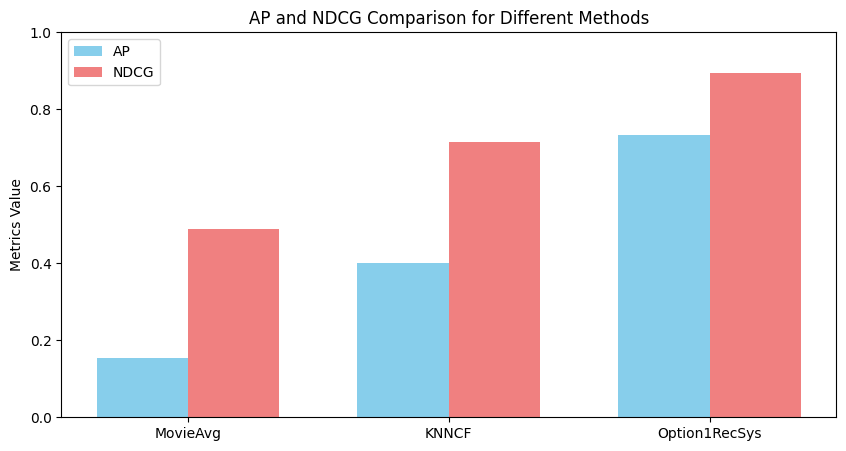

In [18]:
# Mean values for AP and NDCG for different methods
mean_ap_values = [mean_ap_movie_avg, mean_ap_cosine, mean_ap_baseline]
mean_ndcg_values = [mean_ndcg_movie_avg, mean_ndcg_cosine, mean_ndcg_baseline]

# Methods for comparison
methods = ["MovieAvg", "KNNCF", "Option1RecSys"]

# Set the bar width
bar_width = 0.35

# Create an array for the x-axis positions
x = np.arange(len(methods))

# Create the bar chart for AP
plt.figure(figsize=(10, 5))
plt.bar(x - bar_width / 2, mean_ap_values, bar_width, label='AP', color='skyblue')

# Create the bar chart for NDCG
plt.bar(x + bar_width / 2, mean_ndcg_values, bar_width, label='NDCG', color='lightcoral')

# Set the x-ticks and labels
plt.xticks(x, methods)

# Set the y-axis label
plt.ylabel("Metrics Value")

# Set the title
plt.title("AP and NDCG Comparison for Different Methods")

# Add a legend
plt.legend()

plt.ylim(0, 1)  # Set the y-axis range (0 to 1)
plt.show()